In [1]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az

In [2]:
df = pd.read_excel("data.xlsx")
df.columns = ['date', 'day', 'died', 'living', 'dead', 'dead%', 'remaining%', 'change%']
df['date'] = pd.to_datetime(df['date'])

/var/folders/5g/_8fpwryd3h74hzl23fw2zx740000gn/T/ipykernel_65925/478216658.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [3]:
dft = df[(df['day'] > 1)]

<Axes: xlabel='day', ylabel='dead%'>

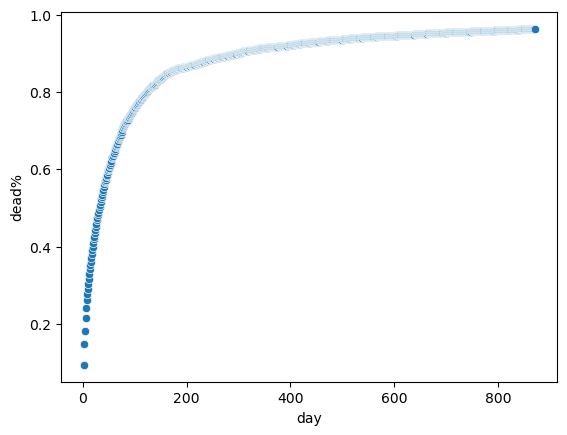

In [4]:
sns.scatterplot(data=dft, x="day", y="dead%")

In [18]:
with pm.Model() as split_model:
    days = pm.Data('days', dft['day'].values)
    # Prior for the change point
    tau = pm.DiscreteUniform('tau', lower=np.min(dft['day'].values)+1, upper=np.max(dft['day'].values)-1)

    # Priors for the parameters before and after the change point
    sigma_eta_before = pm.Exponential("sigma_eta_before", 10)
    sigma_eta_after = pm.Exponential("sigma_eta_after", 10)
    sigma_beta_before = pm.Exponential("sigma_beta_before", 0.05)
    sigma_beta_after = pm.Exponential("sigma_beta_after", 0.05)

    eta_before = pm.Normal("eta_before", 100, 30)
    eta_after = pm.Normal("eta_after", 100, 30)
    beta_before = pm.Normal("beta_before", 1, 0.3)
    beta_after = pm.Normal("beta_after", 1, 0.3)

    
    # Link parameters to model by segment
    eta = pm.math.switch(tau >= days, eta_before, eta_after)
    beta = pm.math.switch(tau >= days, beta_before, beta_after)

    # Weibull-like regression model
    regression = 1 - pm.math.exp(-((days)/eta)**beta)
    sd = pm.HalfNormal("sd", sigma=0.05)

    # Likelihood
    likelihood = pm.Normal("y", mu=regression, sigma=sd, shape=days.shape, observed=dft['dead%'].values)

    # Sampling
    trace_split = pm.sample(tune=10000, draws=5000)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━  72% 0:00:31 / 0:01:17

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━  74% 0:00:31 / 0:01:19

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━  77% 0:00:27 / 0:01:23

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
future_days = np.arange(1, 30000)
with split_model:
    pm.set_data({"days": future_days})
    ppc = pm.sample_posterior_predictive(trace_split, predictions=True)

# Extract predictive samples
predicted_data = ppc.predictions.y

mean_predicted = np.mean(np.mean(predicted_data, axis=0), axis=0)
ci_lower = np.mean(np.percentile(predicted_data, 10, axis=1), axis=0)
ci_upper = np.mean(np.percentile(predicted_data, 90, axis=1), axis=0)

Sampling: [y]


Output()

In [29]:
end_percent = (7141-1)/7141
eta_future = np.mean(np.mean(trace_split.posterior['eta_after'], axis=1))
beta_future = np.mean(np.mean(trace_split.posterior['beta_after'], axis=1))
end_date =  np.ceil(eta_future*((-np.log(1-end_percent))**(1/beta_future)))
end_date

<xarray.DataArray ()> Size: 8B
array(15513.)

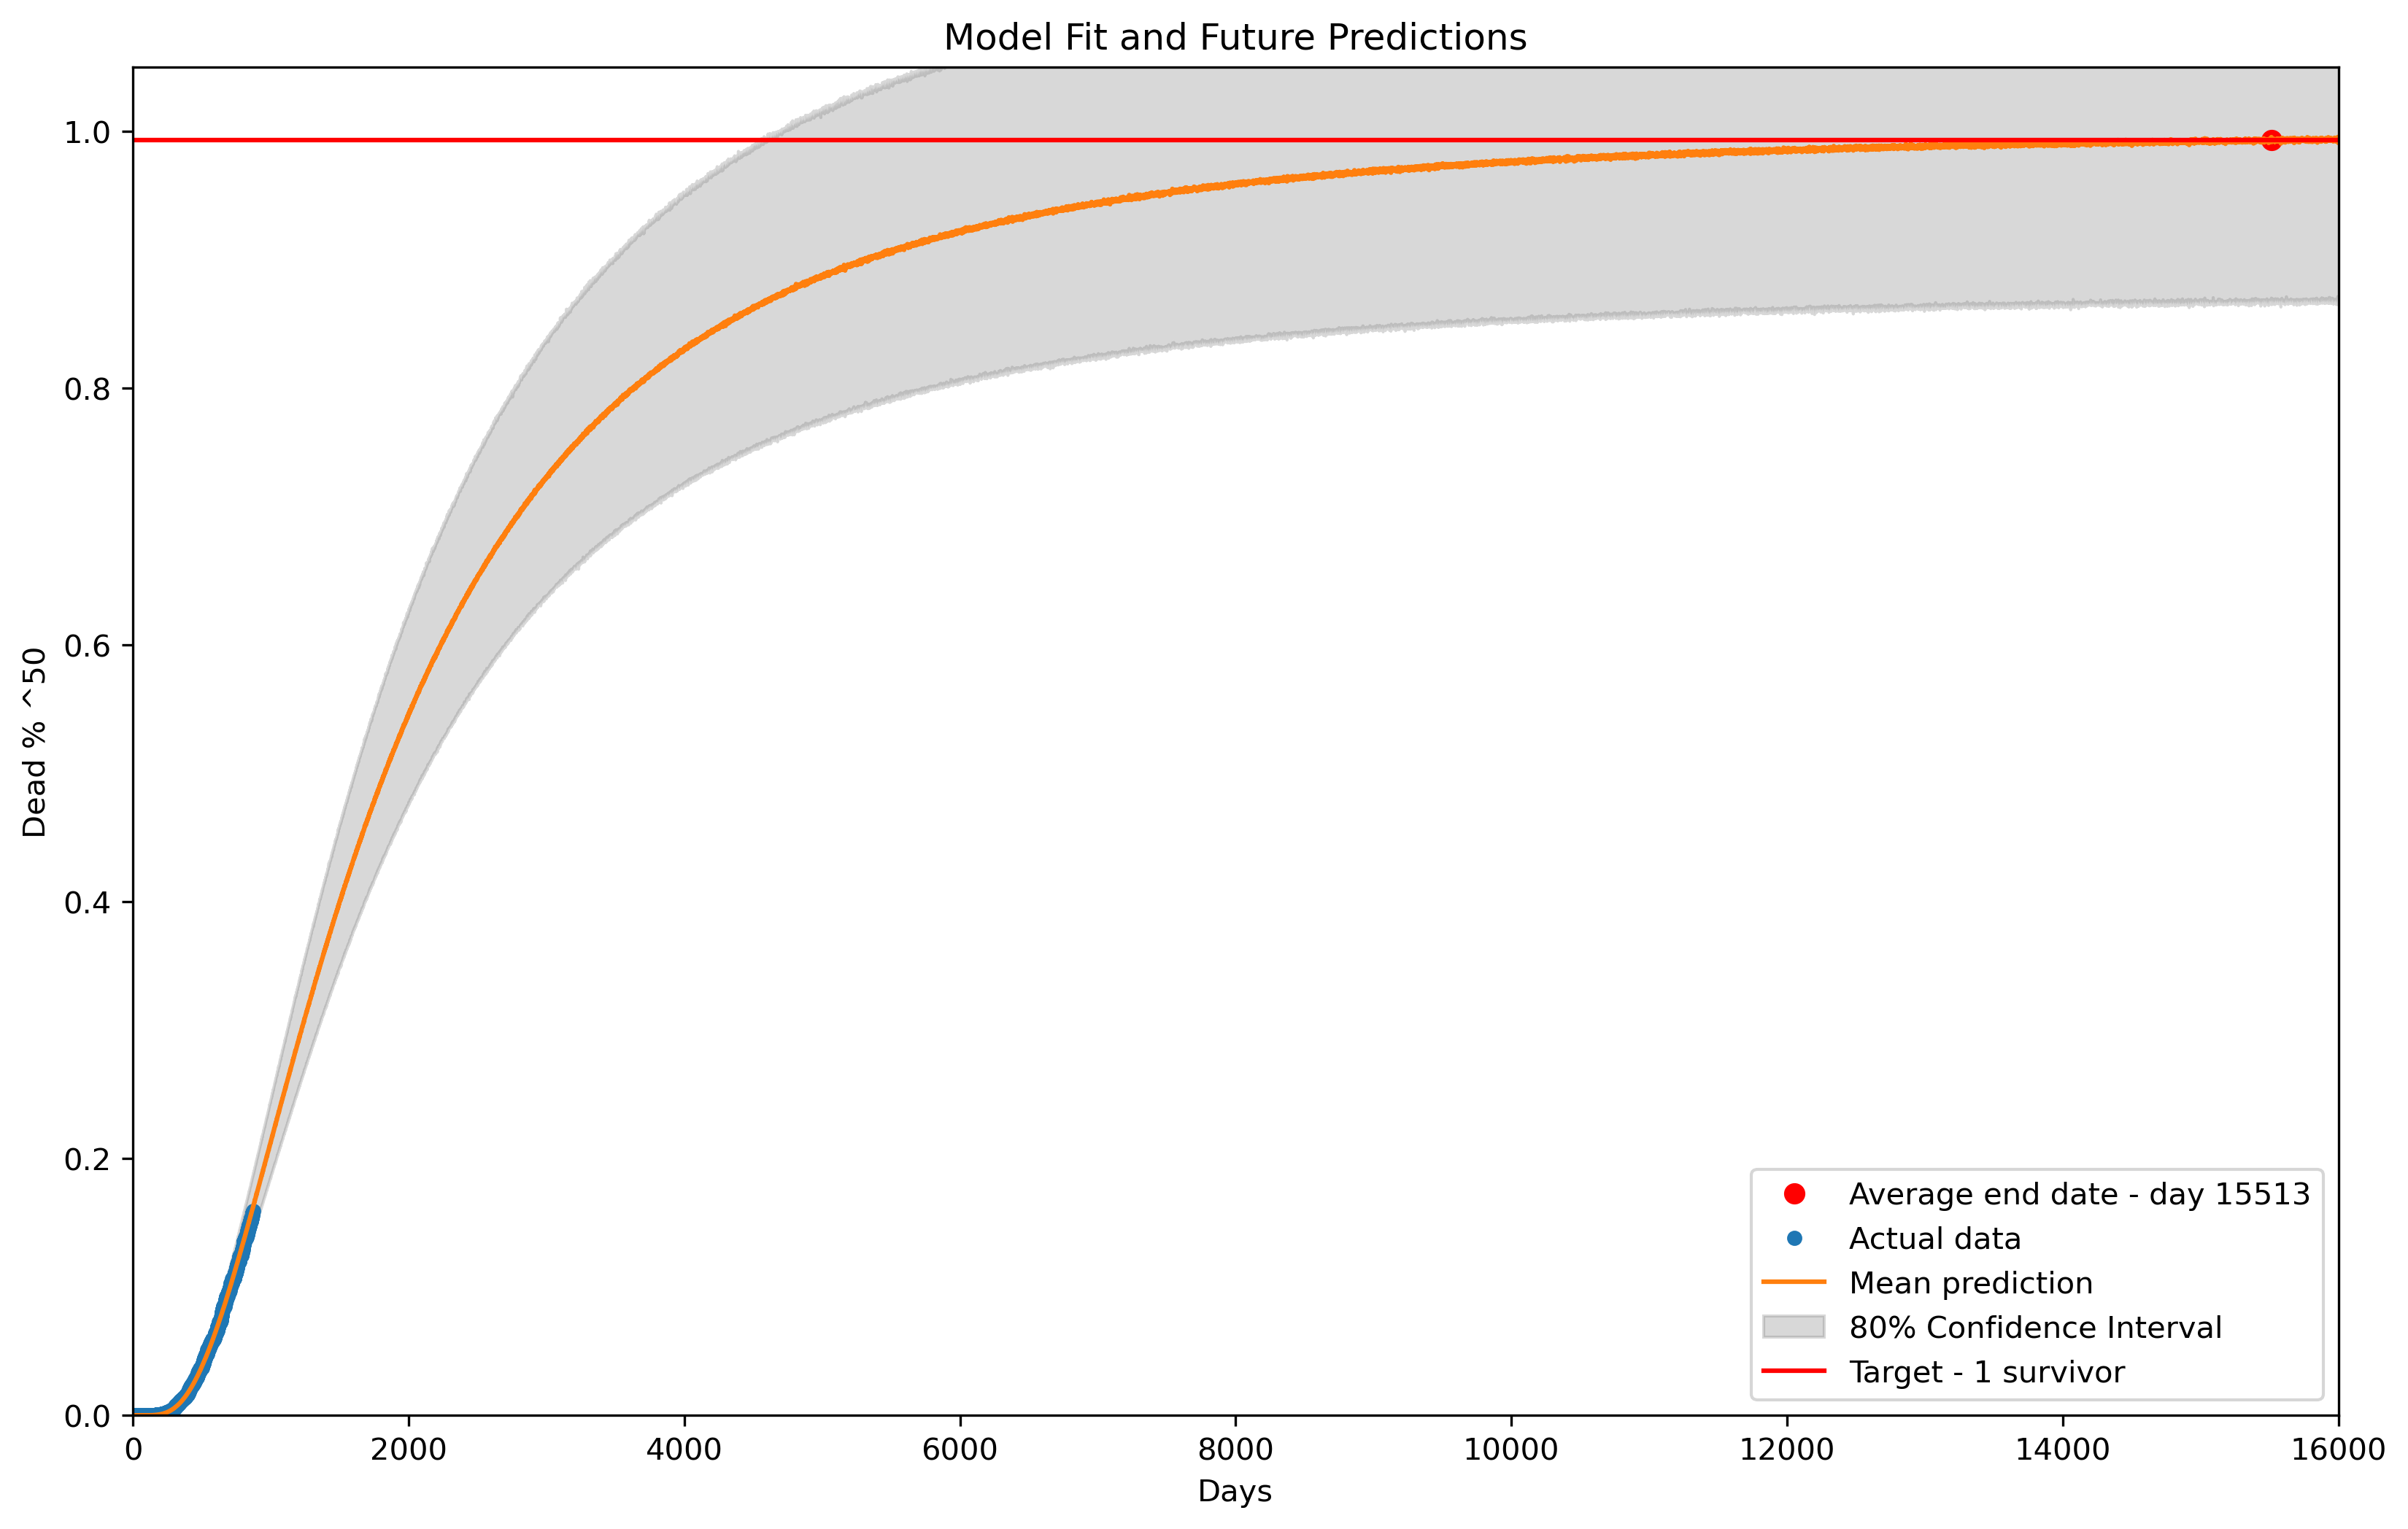

In [54]:
# Existing days for plotting
start = 0
end = 16000
power = 50

plt.figure(figsize=(13, 8), dpi=300)
if end_date > start and end_date < end:
    plt.plot(end_date, end_percent**power, 'ro', label = f'Average end date - day {int(end_date)}')
plt.plot(dft['day'].values, (dft['dead%'].values)**power, 'o', label='Actual data', markersize=4)
plt.plot(future_days, mean_predicted**power, label='Mean prediction')

# Fill between for confidence intervals
plt.fill_between(future_days, ci_lower**power, ci_upper**power, color='gray', alpha=0.3, label='80% Confidence Interval')
plt.axhline(y=end_percent**power, color='r', linestyle='-', label="Target - 1 survivor")

plt.xlim(start, end)
plt.ylim(0, 1.05)

plt.xlabel('Days')
plt.ylabel(f'Dead % ^{power}')
plt.title('Model Fit and Future Predictions')
plt.legend()
plt.show()


array([[<Axes: title={'center': 'beta_after'}>,
        <Axes: title={'center': 'beta_before'}>,
        <Axes: title={'center': 'eta_after'}>],
       [<Axes: title={'center': 'eta_before'}>,
        <Axes: title={'center': 'sd'}>,
        <Axes: title={'center': 'sigma_beta_after'}>],
       [<Axes: title={'center': 'sigma_beta_before'}>,
        <Axes: title={'center': 'sigma_eta_after'}>,
        <Axes: title={'center': 'sigma_eta_before'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: >, <Axes: >]],
      dtype=object)

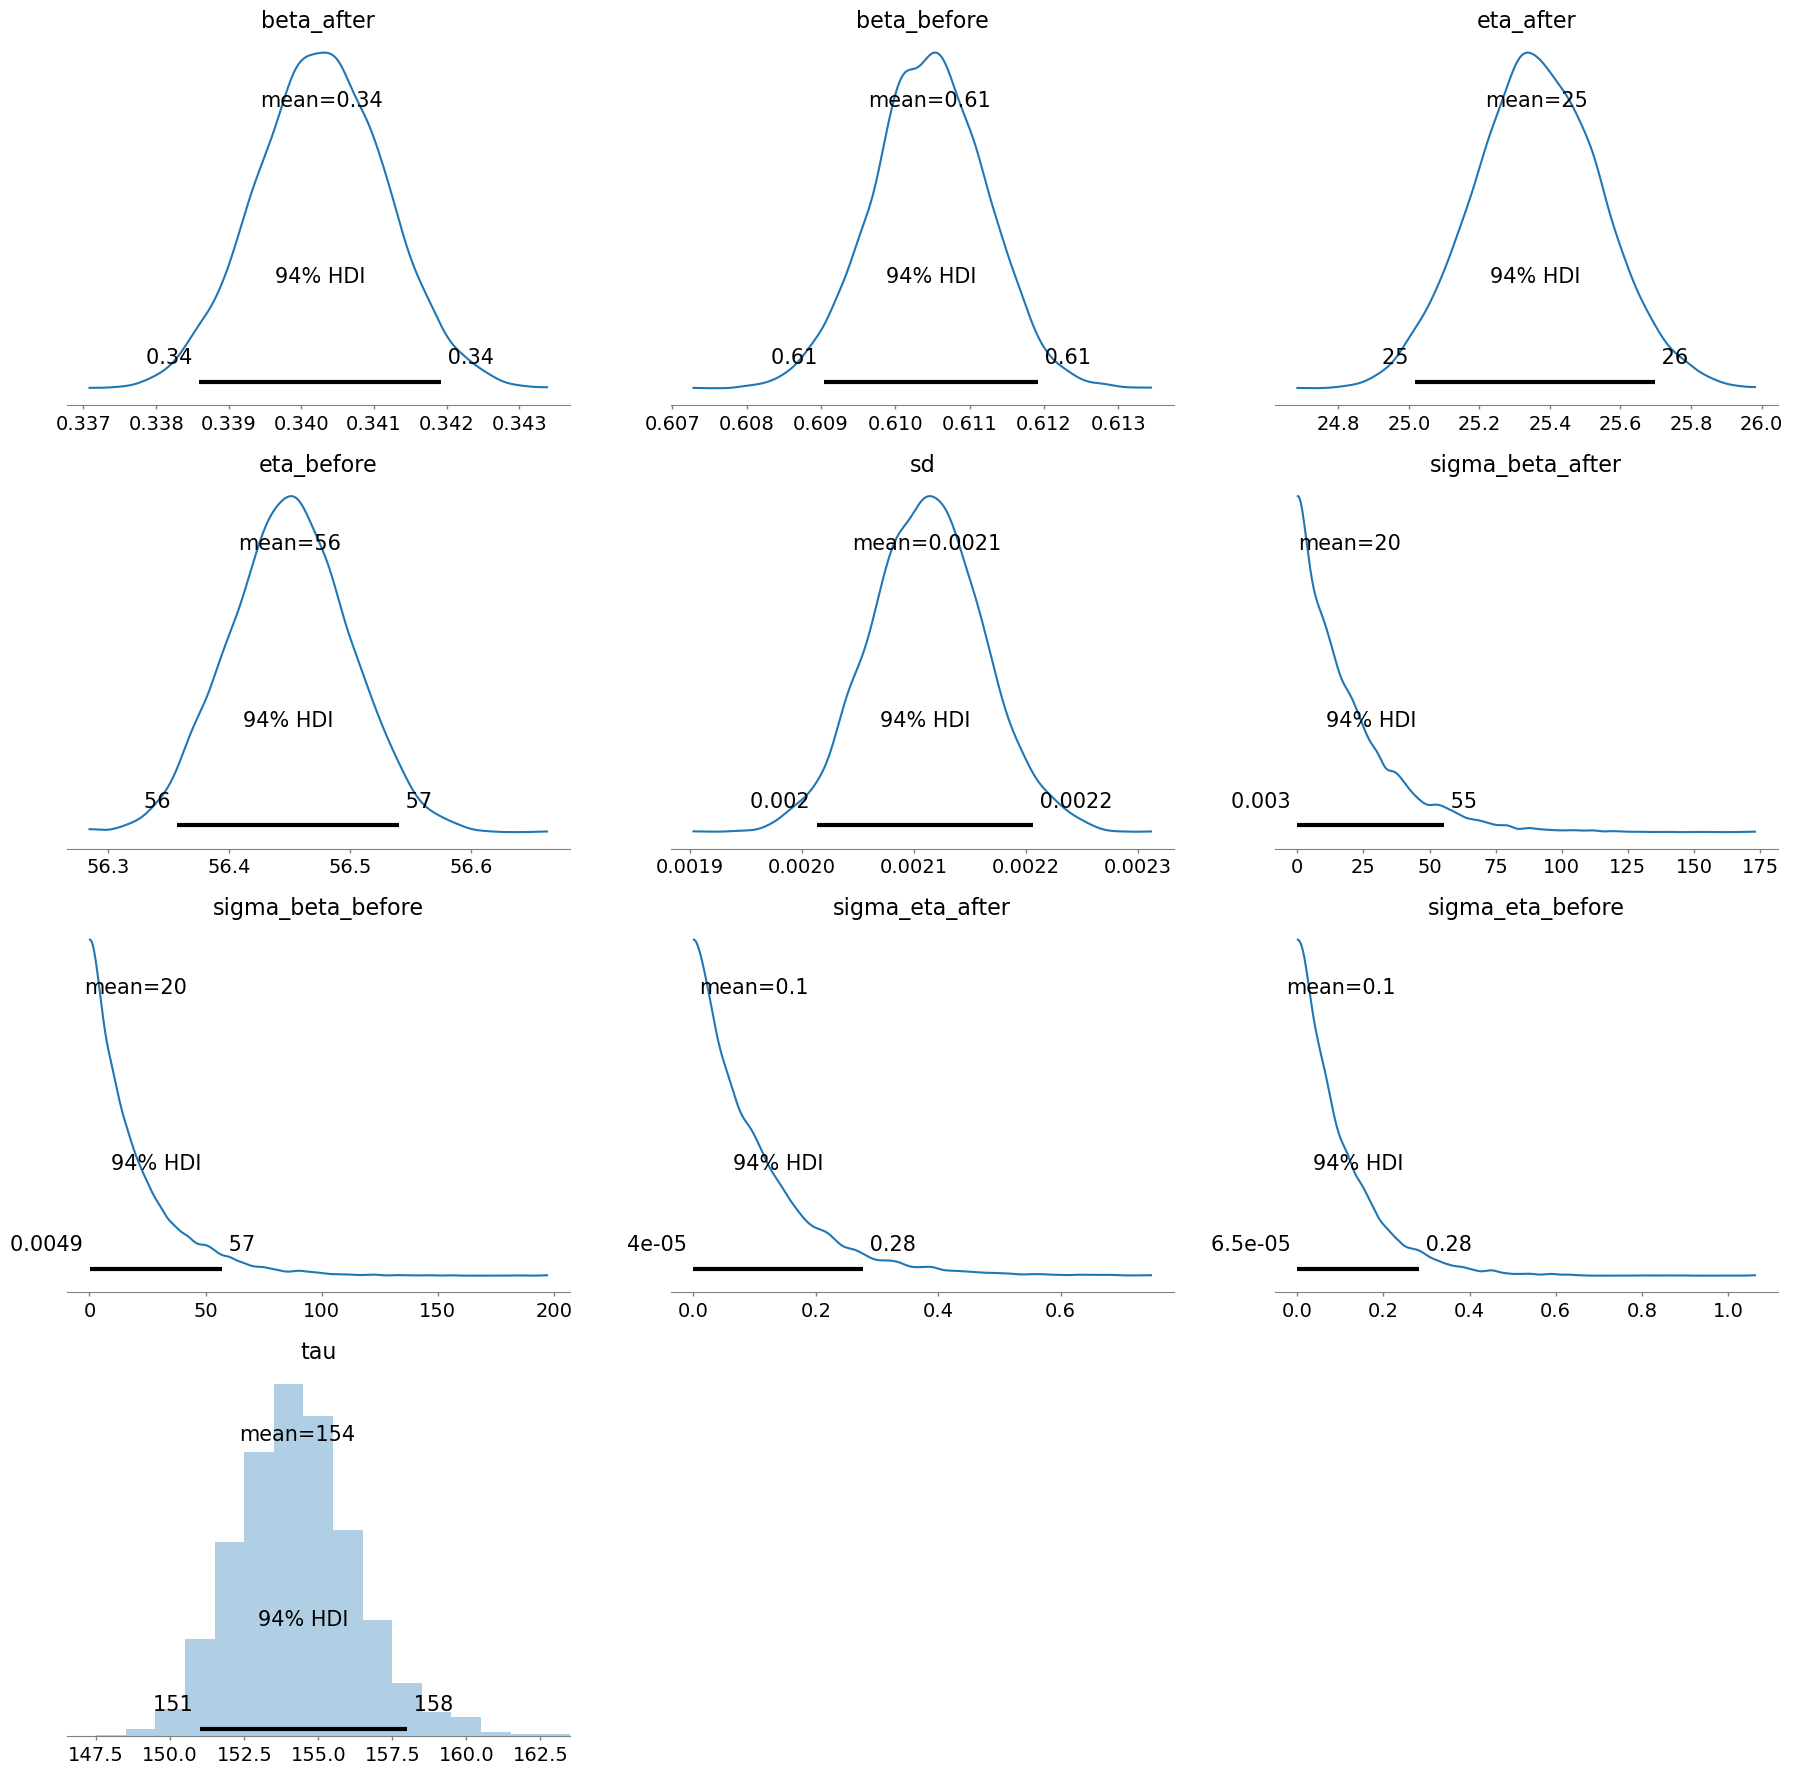

In [140]:
pm.plot_posterior(trace_split.posterior)

In [47]:
days = dft['day'].values  # Time variable

with pm.Model() as model_split3:
    # Priors for the change points
    tau1 = pm.DiscreteUniform('tau1', lower=np.min(days)+1, upper=np.max(days)-1, initval=(np.max(days)-1)//3)
    tau2 = pm.DiscreteUniform('tau2', lower=np.min(days)+1, upper=np.max(days)-1, initval=2*(np.max(days)-1)//3)

    # Ensure tau1 < tau2
    switch = pm.Potential('switch', pm.math.switch(tau1 < tau2, 0, -np.inf))

    # Priors for the parameters in each segment
    sigma_eta_1 = pm.Exponential("sigma_eta_1", 1)
    sigma_eta_2 = pm.Exponential("sigma_eta_2", 1)
    sigma_eta_3 = pm.Exponential("sigma_eta_3", 1)
    sigma_beta_1 = pm.Exponential("sigma_beta_1", 0.05)
    sigma_beta_2 = pm.Exponential("sigma_beta_2", 0.05)
    sigma_beta_3 = pm.Exponential("sigma_beta_3", 0.05)

    eta_1 = pm.Normal("eta_1", 100, 30)
    eta_2 = pm.Normal("eta_2", 100, 30)
    eta_3 = pm.Normal("eta_3", 100, 30)
    beta_1 = pm.Normal("beta_1", 1, 0.3)
    beta_2 = pm.Normal("beta_2", 1, 0.3)
    beta_3 = pm.Normal("beta_3", 1, 0.3)

    # Link parameters to model by segments based on change points
    eta = pm.math.switch(days < tau1, eta_1,
                         pm.math.switch(days < tau2, eta_2, eta_3))
    beta = pm.math.switch(days < tau1, beta_1,
                          pm.math.switch(days < tau2, beta_2, beta_3))

    # Weibull-like regression model
    regression = 1 - pm.math.exp(-((days)/eta)**beta)
    sd = pm.HalfNormal("sd", sigma=0.05)

    # Likelihood
    likelihood = pm.Normal("y", mu=regression, sigma=sd, observed=dft['dead%'].values)

    # Sampling
    trace_split3 = pm.sample(tune=3000, draws=1500)


Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━  90% 0:00:07 / 0:01:22

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━  96% 0:00:03 / 0:01:26

Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 90 seconds.


array([[<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'eta_1'}>,
        <Axes: title={'center': 'eta_2'}>,
        <Axes: title={'center': 'eta_3'}>],
       [<Axes: title={'center': 'sd'}>,
        <Axes: title={'center': 'sigma_beta_1'}>,
        <Axes: title={'center': 'sigma_beta_2'}>],
       [<Axes: title={'center': 'sigma_beta_3'}>,
        <Axes: title={'center': 'sigma_eta_1'}>,
        <Axes: title={'center': 'sigma_eta_2'}>],
       [<Axes: title={'center': 'sigma_eta_3'}>,
        <Axes: title={'center': 'tau1'}>,
        <Axes: title={'center': 'tau2'}>]], dtype=object)

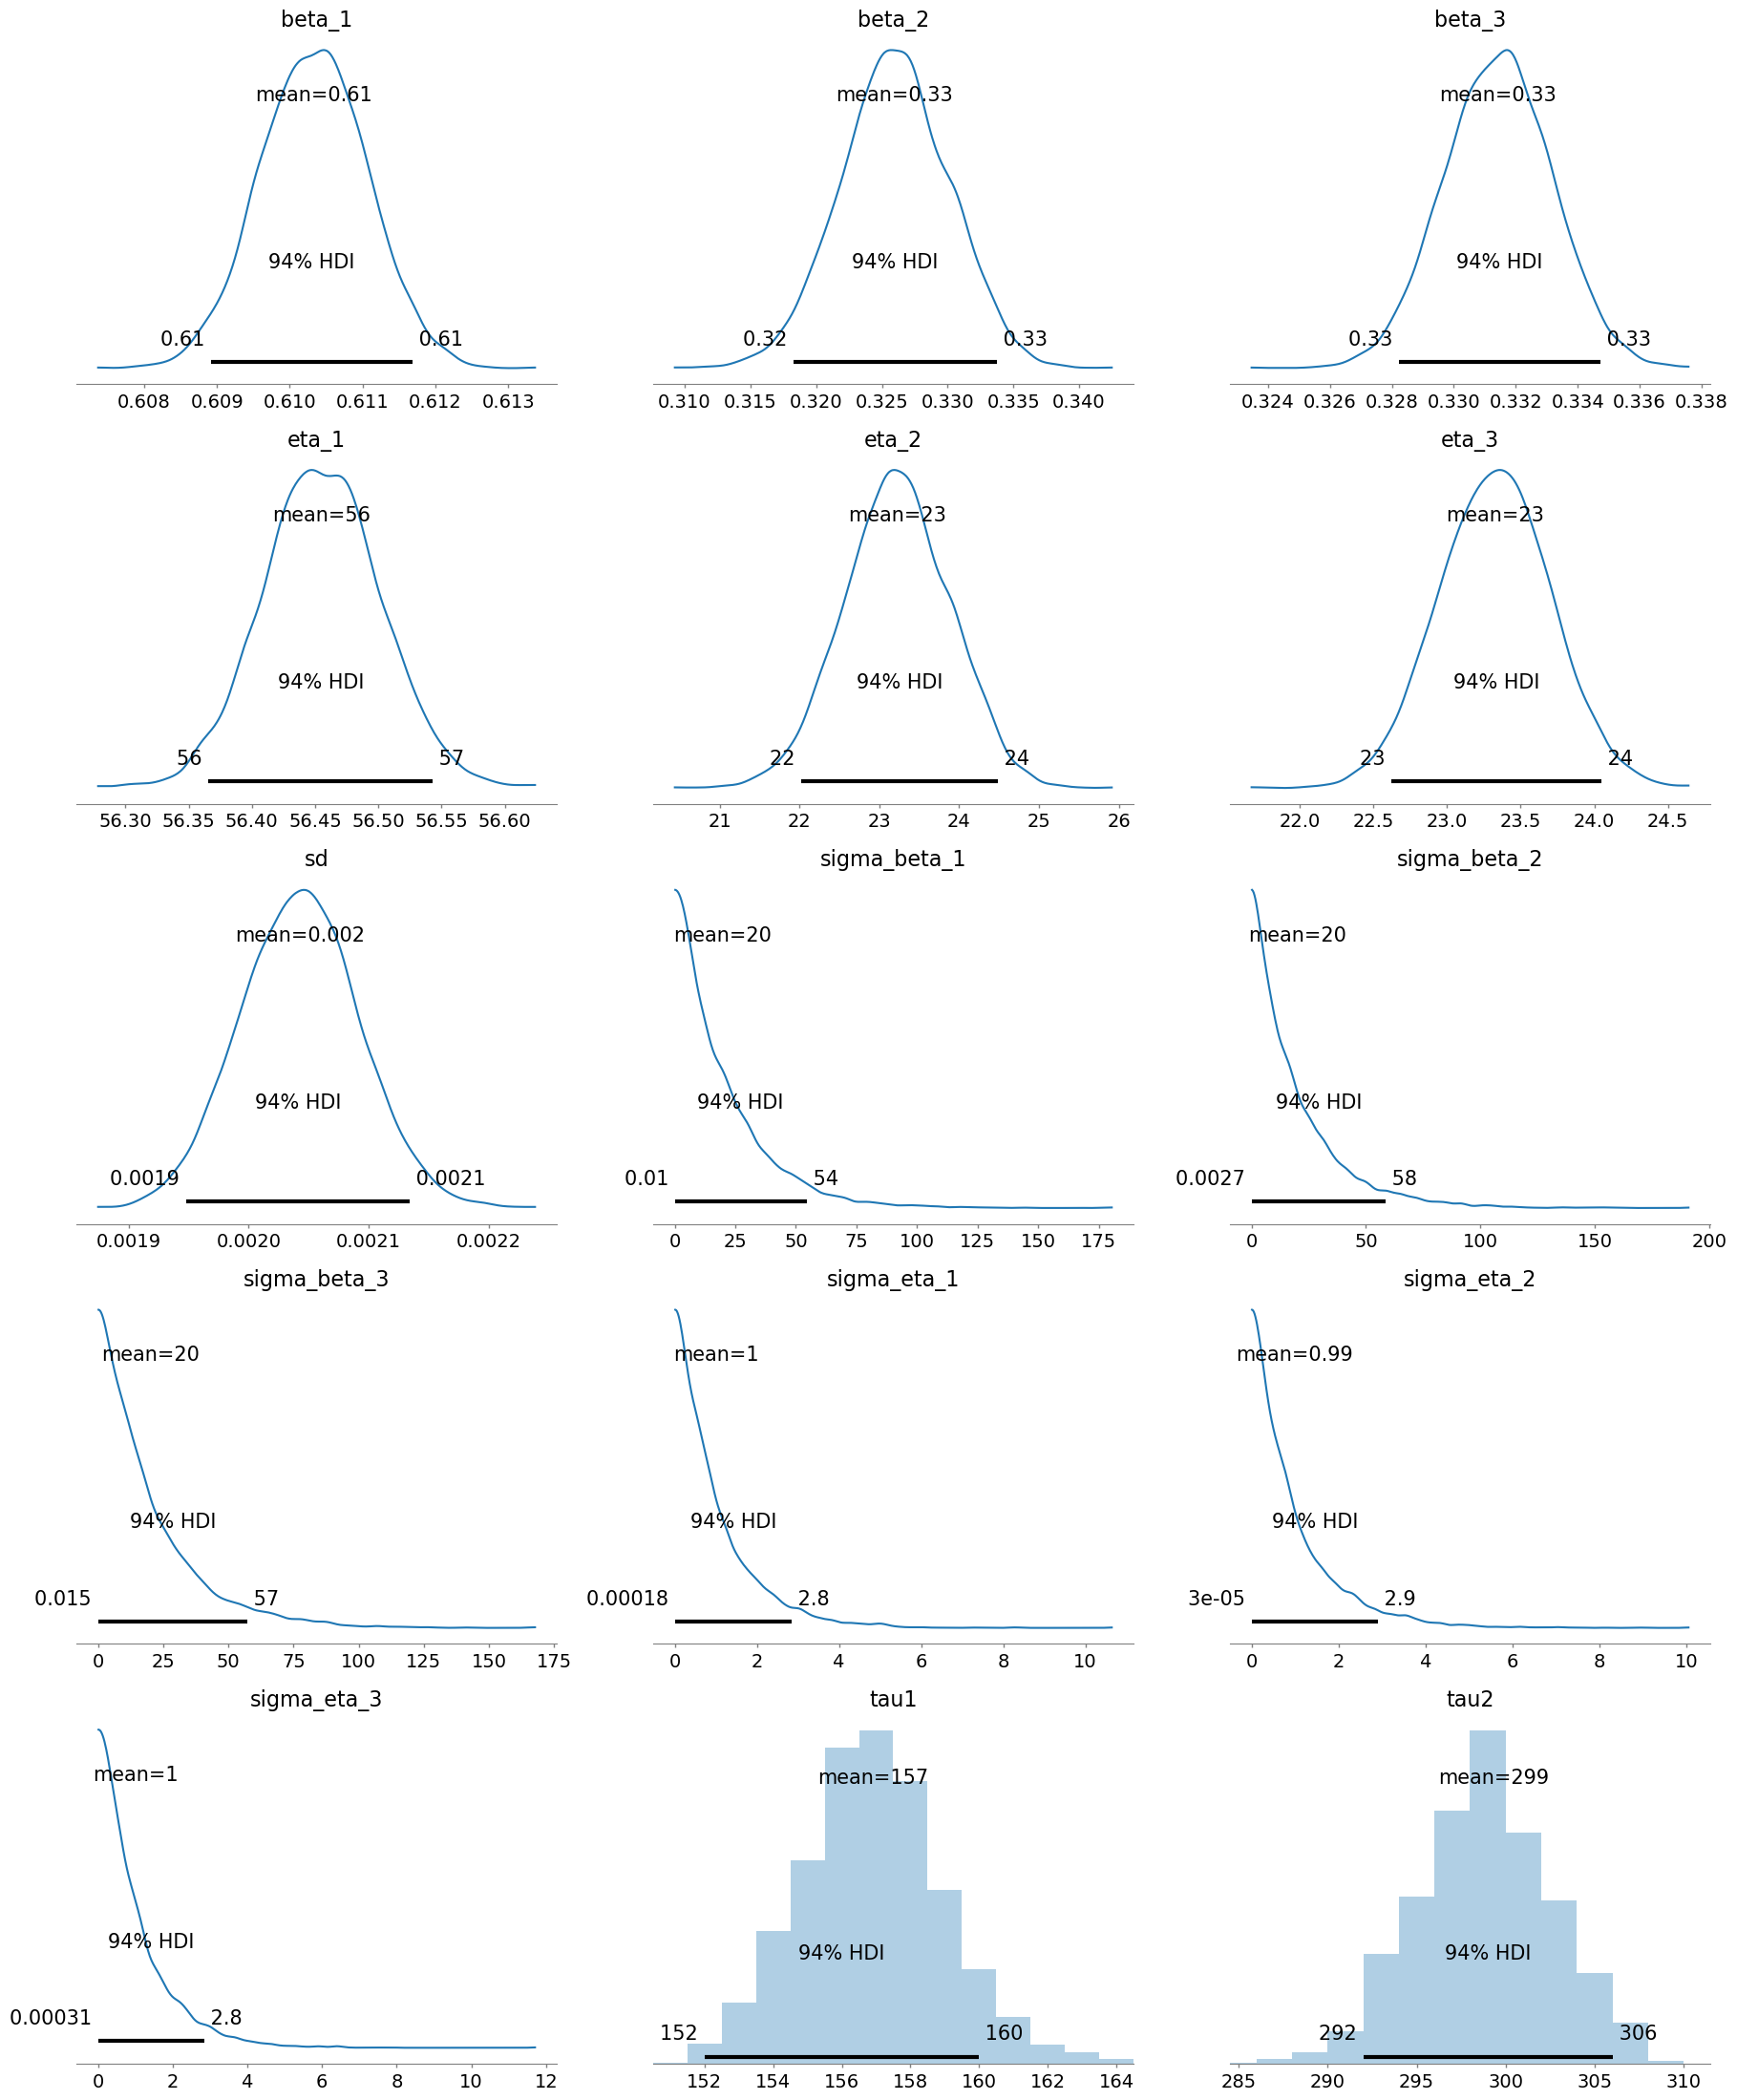

In [48]:
# Here we can see that 3 point split does not increase accuracy
pm.plot_posterior(trace_split3)